# Beaver Bay Complex anorthosite and diabase paleointensity result compilation

We performed a comparative experiment of IZZI modified Thellier paleoitensity experiment on the diabase and anorthosite with a group having 20 mT AF treatment after each in-field step and another group without. The lab field was 30 $\mu$T. As in this attempt for selection criteria, we are using the statistics suggested in Sprain (2018) which studied paleointensities recorded by the volcanics in the Midcontinent Rift of similar age as the Beaver bay Complex. The selection criteria are:
- MAD < 20
- $\beta < 15%$
- DANG < 5$^\circ$
- FRAC > 0.6
- SCAT = TRUE
- GAP-AMX < 0.6
- NpTRM > 2
- N Arai $\geq$ 4

This selection criteria works well, and reports an overall high success rate in the AX group and low sucess rate in BD group, reflecting apparent Arai plot appearance that most BD specimens have curved Arai plots and AX have straight Arai plots. 
In addition, the only BD site that passed the selection, site BD2, yielded a high field estiamte, about 70 $\mu$T, which is suprisingly consistent with many of the accepted AX PINT results. However, it is important to note that the accepted part of Arai plots in this site is the low temperature part (< 500$^\circ$C), contrasting the situation in AX specimens' narrow unblocking temperature near Curie temperature 580$^\circ$C

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import stats
from IPython.display import display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
ipmag.common_mean_watson??

Signature:
ipmag.common_mean_watson(
    Data1,
    Data2,
    NumSims=5000,
    print_result=True,
    plot='no',
    save=False,
    save_folder='.',
    fmt='svg',
)
Source:   
def common_mean_watson(Data1, Data2, NumSims=5000, print_result=True, plot='no', save=False, save_folder='.', fmt='svg'):
    """
    Conduct a Watson V test for a common mean on two directional data sets.

    This function calculates Watson's V statistic from input files through
    Monte Carlo simulation in order to test whether two populations of
    directional data could have been drawn from a common mean. The critical
    angle between the two sample mean directions and the corresponding
    McFadden and McElhinny (1990) classification is printed.

    Parameters
    ----------
    Data1 : a nested list of directional data [dec,inc] (a di_block)
    Data2 : a nested list of directional data [dec,inc] (a di_block)
    NumSims : number of Monte Carlo simulations (default is 5000)
    print_result : defau

## defining functions for reading columns and plotting data

In [3]:
def get_specimen_list(SAM_file_path):
    this_file = open(SAM_file_path, 'r')
    lines = this_file.readlines()
    specimen_list = list()
    for i in range (2, len(lines)):
        thisline = lines[i].split('\n')
        specimen_list.append(thisline[0])
    return specimen_list

def get_PINT_data(site_df, spec_df):
    site_list = site_df.er_site_name.tolist()
    site_int_n = site_df.site_int_n.tolist()
    site_int = site_df.site_int_uT.tolist()
    site_int_sigma_uT = site_df.site_int_sigma_uT.tolist()
    spec_int_uT = spec_df.specimen_int_uT.tolist()
    spec_name_list = spec_df.er_specimen_name.tolist()
    
    return site_list, site_int_n, site_int, site_int_sigma_uT, spec_int_uT, spec_name_list

def get_percent_removed(spec_file_path):
    this_file = open(spec_file_path, 'r')
    lines = this_file.readlines()[2:]
    step_list = list()
    moment_list = list()
    for i in range(len(lines)):
        step_list.append(str(lines[i][0:6]))
        moment_list.append(float(lines[i][31:39]))
    
#     print(step_list)
#     print(moment_list)
    NRM_moment = moment_list[step_list.index('NRM   ')]
    min_moment = min(moment_list)
    
    return 1-min_moment/NRM_moment


def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, np.sqrt(variance)

def plot_PINT(site_list, site_int_n, site_int, site_int_sigma_uT, spec_int_uT, spec_name_list, AF_spec_list=[], plot_weighted_mean = True):
    
    
    site_mean_color = 'black'
    site_std_color = 'grey'
    
    grand_mean_color = 'orange'
    grand_std_color = 'orange'
    weighted_mean_color = 'orange'
    
    current_site = 1
    current_spec = 0
    
    fig, ax = plt.subplots(figsize = (14, 8))
    
    # first lets plot the site mean and sigma
    for i in range(len(site_list)):
        ax.plot([current_site, current_site + site_int_n[i] - 1], [site_int[i], site_int[i]], color = site_mean_color)
        rectangle = matplotlib.patches.Rectangle((current_site, site_int[i]-site_int_sigma_uT[i]), site_int_n[i] - 1, 2*site_int_sigma_uT[i], color = site_std_color, alpha = 0.3)
        
        ax.add_patch(rectangle)
        
        ax.text(current_site + site_int_n[i]/2+0.3, site_int[i] + site_int_sigma_uT[i] + 2.5,
                 site_list[i] + '\n' + '%.2f' % site_int[i] + ' $\pm$ ' + '%.2f' % site_int_sigma_uT[i], size='10',horizontalalignment='center', verticalalignment='bottom', multialignment='center')
        
        # now lets put in little squares of specimen data into site mean plot
        for j in range(site_int_n[i]):
            if spec_name_list[current_spec + j] in AF_spec_list:
                ax.scatter(current_site + j, spec_int_uT[current_spec + j], marker = 's', s = 50, color = 'lightcoral', zorder = 100)
            else:
                ax.scatter(current_site + j, spec_int_uT[current_spec + j], marker = 's', s = 50, color = 'dodgerblue', zorder = 100)
        current_spec = current_spec + site_int_n[i]
        current_site = current_site + site_int_n[i] + 1
        
    # now lets try to plot the grand mean of all sites
    grand_mean = np.mean(site_int)
    grand_std = np.std(site_int)
    print(grand_mean, grand_std)
    
    inverse_int_sigma = [1/site_int_sigma_uT[i] for i in range(len(site_int_sigma_uT))]
    inverse_int_sigma_sum = sum(inverse_int_sigma)
    inverse_int_sigma_weight = [inverse_int_sigma[i]/inverse_int_sigma_sum for i in range(len(inverse_int_sigma))]

    weighted_mean = weighted_avg_and_std(site_int, weights = inverse_int_sigma_weight)[0]
    weighted_std = weighted_avg_and_std(site_int, weights = inverse_int_sigma_weight)[1]
    print(weighted_mean)
    print(weighted_std)
    
    if plot_weighted_mean == True:
        ax.plot([-10, len(spec_int_uT)+50], [weighted_mean, weighted_mean], linestyle = 'dashed', color = weighted_mean_color)
        ax.fill_between([-10, len(spec_int_uT)+50], 
                        [weighted_mean-weighted_std, weighted_mean-weighted_std], 
                        [weighted_mean+weighted_std, weighted_mean+weighted_std], 
                        color = grand_std_color, alpha = 0.1)
#         ax.plot([-10, len(spec_int_uT)+50], [weighted_mean+weighted_std, weighted_mean+weighted_std], linestyle = 'dashed', color = grand_std_color, alpha = 0.5)
        return fig, ax, weighted_mean, weighted_std 
    else:
         
        ax.plot([-10, len(spec_int_uT)+50], [grand_mean, grand_mean], linestyle = 'dashed', color = grand_mean_color)
#         ax.plot([-10, len(spec_int_uT)+50], [grand_mean-grand_std, grand_mean-grand_std], linestyle = 'dashed', color = grand_std_color, alpha = 0.5)
#         ax.plot([-10, len(spec_int_uT)+50], [grand_mean+grand_std, grand_mean+grand_std], linestyle = 'dashed', color = grand_std_color, alpha = 0.5)
        return fig, ax, grand_mean, grand_std
#     grand_mean_rectangle = matplotlib.patches.Rectangle((-10, grand_mean-grand_std), len(spec_int_uT)+50, 2*grand_std, color = 'lightgreen', alpha = 0.4)
#     plt.gca().add_patch(grand_mean_rectangle)
    
    # now lets make some legend

## Loading magnetometer file to calculate the percentage of NRM removed for each specimen

In [4]:
All_AX_spec_list = list()
All_AX_spec_list.extend(get_specimen_list('../data/IZZI/All_AX_PINT/AX_AF_PINT.sam'))
All_AX_spec_list.extend(get_specimen_list('../data/IZZI/All_AX_PINT/AX_NRM_PINT.sam'))

All_AX_spec_list.sort()

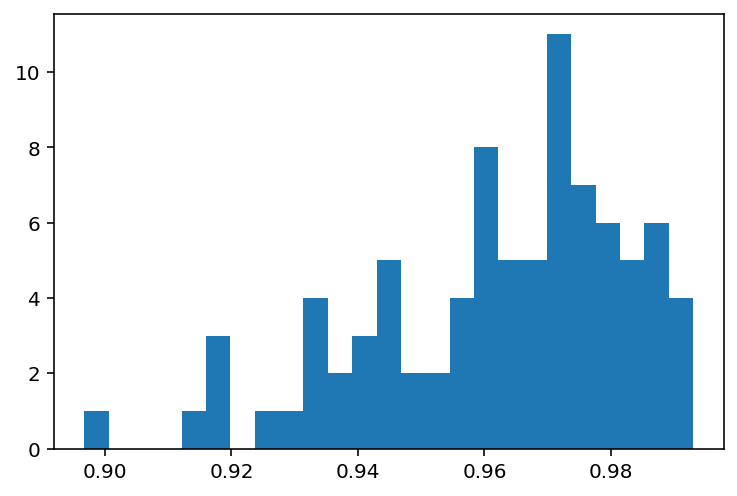

In [5]:
percent_remove_list = list()
for i in range(len(All_AX_spec_list)):
    percent_remove_list.append(get_percent_removed('../data/IZZI/All_AX_PINT/' + All_AX_spec_list[i]))

plt.hist(percent_remove_list, bins=25)
plt.show()

## Loading MagIC data file

In [6]:
# Loading files
AX_all_PINT_site = pd.read_csv('../data/IZZI/All_AX_PINT/thellier_interpreter/thellier_interpreter_STDEV-OPT_sites.txt', sep = '\t', header = 4)
AX_all_PINT_specimen = pd.read_csv('../data/IZZI/All_AX_PINT/thellier_interpreter/thellier_interpreter_STDEV-OPT_specimens.txt', sep = '\t', header = 1)

# try dropping out AX6
# AX_all_PINT_site = AX_all_PINT_site.drop(AX_all_PINT_site[AX_all_PINT_site['er_site_name'].str.contains('AX6')].index)
# AX_all_PINT_specimen = AX_all_PINT_specimen.drop(AX_all_PINT_specimen[AX_all_PINT_specimen['er_sample_name'].str.contains('AX6')].index)
BD_all_PINT_site = pd.read_csv('../data/IZZI/All_BD_PINT//thellier_interpreter/thellier_interpreter_STDEV-OPT_sites.txt', sep = '\t', header = 4)
BD_all_PINT_specimen = pd.read_csv('../data/IZZI/All_BD_PINT/thellier_interpreter/thellier_interpreter_STDEV-OPT_specimens.txt', sep = '\t', header = 1)

In [7]:
# get the lists of  AF pretreatment specimens and those without
AX_AF_spec_list = get_specimen_list('../data/IZZI/AX_AF_PINT/AX_AF_PINT.sam')
BD_AF_spec_list = get_specimen_list('../data/IZZI/BD_AF_PINT/BD_AF_PINT_old.sam')

All_AF_spec_list = list()
All_AF_spec_list.extend(AX_AF_spec_list)
All_AF_spec_list.extend(BD_AF_spec_list)

## sort data files so that they are ordered by site locations and by ascending paleointensities

In [8]:
AX_all_PINT_site.er_site_name = pd.Categorical(AX_all_PINT_site.er_site_name, ['AX6', 'AX8', 'AX10', 'AX12' ,'AX16', 'AX11', 'AX13'])
AX_all_PINT_site = AX_all_PINT_site.sort_values('er_site_name')
AX_all_PINT_site

,er_site_name,site_int_n,site_int_uT,site_int_sigma_uT,site_int_sigma_perc,site_int_min_uT,site_int_min_sigma_uT,site_int_max_uT,site_int_max_sigma_uT,site_int_interval_uT,site_int_interval_perc,Warning
5,AX6,3,30.33,15.17,50.01,28.81,16.35,32.92,19.548,4.11,13.55,No anisotropy corrections; No cooling rate co...
6,AX8,3,52.40,12.15,23.18,51.41,13.06,54.24,15.151,2.83,5.40,No anisotropy corrections; No cooling rate co...
0,AX10,3,47.78,0.04,0.09,44.67,3.37,64.40,18.545,19.74,41.31,No anisotropy corrections; No cooling rate co...
2,AX12,6,38.03,5.76,15.15,36.78,6.26,41.82,10.152,5.04,13.26,No anisotropy corrections; No cooling rate co...
4,AX16,11,44.15,5.08,11.50,41.20,6.37,50.13,12.905,8.93,20.22,No anisotropy corrections; No cooling rate co...
1,AX11,7,73.34,0.06,0.08,69.03,2.60,76.54,2.797,7.51,10.24,No anisotropy corrections; No cooling rate co...
3,AX13,7,76.73,3.78,4.92,71.51,6.90,78.81,6.084,7.30,9.51,No anisotropy corrections; No cooling rate co...


In [9]:
AX_all_PINT_specimen.er_sample_name = pd.Categorical(AX_all_PINT_specimen.er_sample_name, ['AX6', 'AX8', 'AX10', 'AX12' ,'AX16', 'AX11', 'AX13'])
AX_all_PINT_specimen = AX_all_PINT_specimen.sort_values(['er_sample_name', 'specimen_int_uT'])
AX_all_PINT_specimen.head(10)

,er_sample_name,er_specimen_name,specimen_int_uT,measurement_step_min,measurement_step_min.1,specimen_lab_field_dc,Anisotropy_correction_factor,NLT_correction_factor,Cooling_rate_correction_factor,specimen_int_n,specimen_frac,specimen_int_ptrm_n,specimen_b_beta,specimen_int_mad,specimen_int_dang,specimen_scat
35,AX6,AX6-2a,18.25,400,585,30,1.0,-,-,18.0,0.70,10.0,0.04,3.44,3.43,t
36,AX6,AX6-3a,25.39,400,585,30,1.0,-,-,18.0,0.76,10.0,0.04,4.28,2.88,t
34,AX6,AX6-1a,47.36,475,585,30,1.0,-,-,15.0,0.60,10.0,0.02,2.92,1.67,t
39,AX8,AX8-3a,41.30,400,580,30,1.0,-,-,17.0,0.75,9.0,0.03,4.38,2.22,t
38,AX8,AX8-2a,50.51,400,580,30,1.0,-,-,17.0,0.63,9.0,0.04,3.19,1.29,t
37,AX8,AX8-1a,65.38,425,566,30,1.0,-,-,13.0,0.60,8.0,0.07,5.28,2.95,t
0,AX10,AX10-1a,47.74,450,585,30,1.0,-,-,16.0,0.73,10.0,0.06,5.86,2.63,t
2,AX10,AX10-3a,47.76,450,580,30,1.0,-,-,15.0,0.64,9.0,0.04,4.09,1.61,t
1,AX10,AX10-2a,47.82,450,580,30,1.0,-,-,15.0,0.61,9.0,0.05,5.74,2.47,t
10,AX12,AX12-14a,30.34,475,585,30,1.0,-,-,16.0,0.75,10.0,0.06,1.74,0.55,t


In [10]:
BD_all_PINT_specimen = BD_all_PINT_specimen.sort_values('specimen_int_uT')
BD_all_PINT_specimen

,er_sample_name,er_specimen_name,specimen_int_uT,measurement_step_min,measurement_step_min.1,specimen_lab_field_dc,Anisotropy_correction_factor,NLT_correction_factor,Cooling_rate_correction_factor,specimen_int_n,specimen_frac,specimen_int_ptrm_n,specimen_b_beta,specimen_int_mad,specimen_int_dang,specimen_scat
3,BD2,BD2-18a,62.58,100,553,30,1.0,-,-,13.0,0.63,6.0,0.11,4.43,4.74,t
4,BD2,BD2-4b,65.30,100,500,30,1.0,-,-,8.0,0.62,3.0,0.09,2.93,3.26,t
0,BD2,BD2-10a,74.49,100,500,30,1.0,-,-,7.0,0.74,3.0,0.13,2.30,2.11,t
7,BD2,BD2-8b,76.80,0,450,30,1.0,-,-,7.0,0.73,2.0,0.07,6.25,1.90,t
1,BD2,BD2-13a,76.82,0,475,30,1.0,-,-,7.0,0.73,2.0,0.10,4.89,0.90,t
6,BD2,BD2-7b,79.45,0,425,30,1.0,-,-,6.0,0.68,2.0,0.11,8.66,4.66,t
8,BD2,BD2-9a,80.57,0,475,30,1.0,-,-,7.0,0.73,2.0,0.09,3.84,2.19,t
5,BD2,BD2-5b,82.00,0,425,30,1.0,-,-,6.0,0.65,2.0,0.06,3.65,2.18,t
2,BD2,BD2-14a,84.60,100,550,30,1.0,-,-,12.0,0.60,5.0,0.10,4.74,2.91,t


## Get paleolatitude list from directional results 

In [11]:
AX_BD_site_path = '../data/Demag/sites.txt'
AX_BD_site_data = pd.read_csv(AX_BD_site_path, sep='\t',header=1)

In [12]:
# calculate paleolatitude from the inclination data
AX_BD_site_data['paleolatitude'] = pmag.plat(AX_BD_site_data['dir_inc'])

# filter out BD14 and BD16 likely lightning zapped sites
AX_BD_site_data = AX_BD_site_data.drop(AX_BD_site_data[AX_BD_site_data['site'] == 'BD14'].index)
AX_BD_site_data = AX_BD_site_data.drop(AX_BD_site_data[AX_BD_site_data['site'] == 'BD16'].index)

# filter for the mid temp and mid coercivity components after tilt correction 
AX_BD_site_mct_tc = AX_BD_site_data[(AX_BD_site_data['dir_comp_name'].isin(['mc','mt'])) & (AX_BD_site_data['dir_tilt_correction'] == 100)]
AX_site_mct_tc = AX_BD_site_mct_tc[AX_BD_site_mct_tc['site'].str.startswith('AX')]
BD_site_mct_tc = AX_BD_site_mct_tc[AX_BD_site_mct_tc['site'].str.startswith('BD')]

AX_plat = AX_site_mct_tc[['site', 'paleolatitude']].set_index('site')
BD_plat = BD_site_mct_tc[['site', 'paleolatitude']].set_index('site')

AX_plat = pd.Series(data=AX_plat['paleolatitude'], index=AX_plat.index)
BD_plat = pd.Series(data=BD_plat['paleolatitude'], index=BD_plat.index)


In [13]:
AX_BD_site_data['paleolatitude'].mean()

19.87667441398792

In [14]:
AX_site_pair_plat = [AX_site_mct_tc['site'].tolist(), AX_site_mct_tc['paleolatitude'].tolist()]
BD_site_pair_plat = [BD_site_mct_tc['site'].tolist(), BD_site_mct_tc['paleolatitude'].tolist()]

In [15]:
AX_PINT_data = get_PINT_data(AX_all_PINT_site, AX_all_PINT_specimen)
BD_PINT_data = get_PINT_data(BD_all_PINT_site, BD_all_PINT_specimen)
AX_PINT_lat = [AX_plat[i] for i in AX_PINT_data[0]]
BD_PINT_lat = [BD_plat[i] for i in BD_PINT_data[0]]


In [16]:
AX_vdm_list =[round(pmag.b_vdm(AX_PINT_data[2][i]/1e6/1.35, AX_PINT_lat[i]), 2) for i in range(len(AX_PINT_lat))]
BD_vdm_list =[round(pmag.b_vdm(BD_PINT_data[2][i]/1e6/1.35, BD_PINT_lat[i]), 2) for i in range(len(BD_PINT_lat))]
display(AX_vdm_list)
display(BD_vdm_list)

[5.2657937400770685e+22,
 8.937832008835443e+22,
 8.404758550046742e+22,
 5.913626174841906e+22,
 7.08420575577178e+22,
 1.3184271163985688e+23,
 1.3923971530673962e+23]

[1.3693872205715465e+23]

## Let's plot the raw data

51.82285714285714 16.084995416568216
57.92092799758618
12.643282069604025


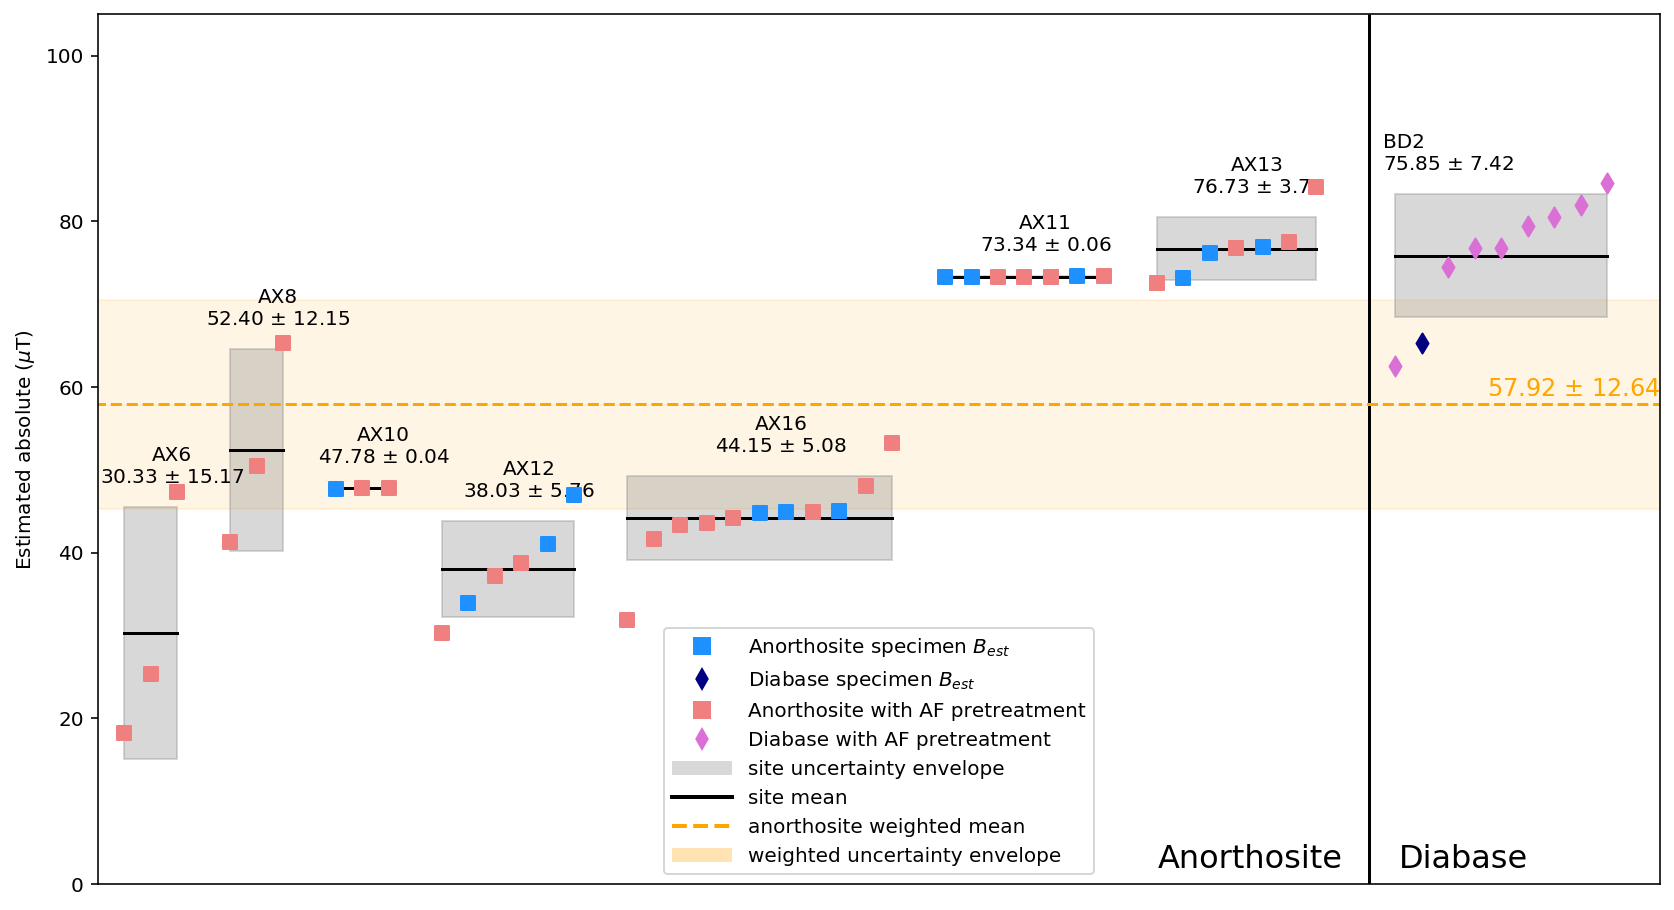

In [17]:
AX_PINT_data = get_PINT_data(AX_all_PINT_site, AX_all_PINT_specimen)
BD_PINT_data = get_PINT_data(BD_all_PINT_site, BD_all_PINT_specimen)

AX_site_mean_color = 'black'
AX_site_std_color = 'grey'
AX_spec_color = 'dodgerblue'
AX_grand_mean_color = 'orange'
AX_weighted_mean_color = 'orange'
AX_grand_std_color = 'orange'
BD_spec_color = 'navy'
plot_weighted_mean = True

fig, ax, mean, std = plot_PINT(AX_PINT_data[0], AX_PINT_data[1], (AX_PINT_data[2]), AX_PINT_data[3], AX_PINT_data[4], AX_PINT_data[5], All_AF_spec_list, plot_weighted_mean)

plt.vlines(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+8, 0, 105)

# lets add the only accepted but double sloped BD site data here
site_list, site_int_n, site_int, site_int_sigma_uT, spec_int_uT, spec_name_list = BD_PINT_data[0], BD_PINT_data[1], BD_PINT_data[2],  BD_PINT_data[3], BD_PINT_data[4], BD_PINT_data[5]

current_site = len(AX_all_PINT_specimen.specimen_int_uT.tolist())+ 8 + 1
current_spec = 0

for i in range(len(site_list)):
    ax.plot([current_site, current_site + site_int_n[i] - 1], [site_int[i], site_int[i]], color = AX_site_mean_color)
    rectangle = matplotlib.patches.Rectangle((current_site, site_int[i]-site_int_sigma_uT[i]), site_int_n[i] - 1, 2*site_int_sigma_uT[i], color = AX_site_std_color, alpha = 0.3)
        
    ax.add_patch(rectangle)
        
    ax.text(current_site + site_int_n[i]/2, site_int[i] + site_int_sigma_uT[i] + 2.5,
                site_list[i] + '\n' + '%.2f' % site_int[i] + ' $\pm$ ' + '%.2f' % site_int_sigma_uT[i], size='10',horizontalalignment='right', verticalalignment='bottom', multialignment='left')
        
    # now lets put in little squares of specimen data into site mean plot
    for j in range(site_int_n[i]):
        if spec_name_list[current_spec + j] in All_AF_spec_list:
            ax.scatter(current_site + j, spec_int_uT[current_spec + j], marker = 'd', s = 50, color = 'orchid', zorder = 100)
        else:
            ax.scatter(current_site + j, spec_int_uT[current_spec + j], marker = 'd', s = 50, color = 'navy', zorder = 100)
    current_spec = current_spec + site_int_n[i]
    current_site = current_site + site_int_n[i] + 1

# labeling grand mean for AX
if plot_weighted_mean == True:
    ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+19, mean+1, '%.2f' % mean + ' $\pm$ ' + '%.2f' % std, color = AX_weighted_mean_color, horizontalalignment='right',fontsize=12)
    # making legends here
    custom_legends = [Line2D([0], [0], marker='s', color='w', markerfacecolor=AX_spec_color, markersize=10, label='Anorthosite specimen $B_{est}$'), 
                      Line2D([0], [0], marker='d', color='w', markerfacecolor=BD_spec_color, markersize=10, label='Diabase specimen $B_{est}$'), 
                      Line2D([0], [0], marker='s', color='w', markerfacecolor='lightcoral', markersize=10, label='Anorthosite with AF pretreatment'), 
                      Line2D([0], [0], marker='d', color='w', markerfacecolor='orchid', markersize=10, label='Diabase with AF pretreatment'), 
                        Patch(facecolor=AX_site_std_color, edgecolor='none', lw = 5, alpha = 0.3, label='site uncertainty envelope'),
                        Line2D([0], [0], color=AX_site_mean_color, lw=2, label = 'site mean'),
                        Line2D([0], [0], color=AX_weighted_mean_color, ls = 'dashed', lw=2, label = 'anorthosite weighted mean'),
                        Patch(facecolor=AX_grand_std_color, edgecolor='none', lw = 5, alpha = 0.3, label= 'weighted uncertainty envelope')]
else:
    ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+13.5, mean+1, '%.2f' % mean + ' $\pm$ ' + '%.2f' % std, color = AX_grand_mean_color, horizontalalignment='right',fontsize=12)
    # making legends here
    custom_legends = [Line2D([0], [0], marker='s', color='w', markerfacecolor=AX_spec_color, markersize=10, label='Anorthosite specimen $B_{est}$'), 
                      Line2D([0], [0], marker='d', color='w', markerfacecolor=BD_spec_color, markersize=10, label='Diabase specimen $B_{est}$'), 
                      Line2D([0], [0], marker='s', color='w', markerfacecolor='lightcoral', markersize=10, label='Anorthosite with AF pretreatment'), 
                      Line2D([0], [0], marker='d', color='w', markerfacecolor='orchid', markersize=10, label='Diabase with AF pretreatment'), 
                        Patch(facecolor=AX_site_std_color, edgecolor='none', lw = 5, alpha = 0.3, label='site uncertainty envelope'),
                        Line2D([0], [0], color=AX_site_mean_color, lw=2, label = 'site mean'),
                        Line2D([0], [0], color=AX_grand_mean_color, ls = 'dashed', lw=2, label = 'anorthosite grand mean'),
                        Line2D([0], [0], color=AX_grand_std_color, linestyle = 'dashed', lw=2, alpha = 0.5, label = 'grand uncertainty envelope')]


ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+7, 2, 'Anorthosite', horizontalalignment='right',fontsize=16)   
ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+14, 2, 'Diabase', horizontalalignment='right',fontsize=16) 
ax.set_xlim(0, len(AX_all_PINT_specimen.specimen_int_uT.tolist())+10+len(BD_all_PINT_specimen.specimen_int_uT.tolist()))
ax.set_ylim(0,105)
ax.set_xticks([])
ax.set_ylabel('Estimated absolute ($\mu$T)')

plt.legend(handles = custom_legends, loc = 8, handlelength = 3)
plt.savefig('code_output/Paleointensity_summary_no_correction.pdf', bbox_inches='tight')
plt.show(fig)

## Let's plot the cooling rate corrected data

38.387301587301586 11.914811419680156
42.9043911093231
9.365394125632609


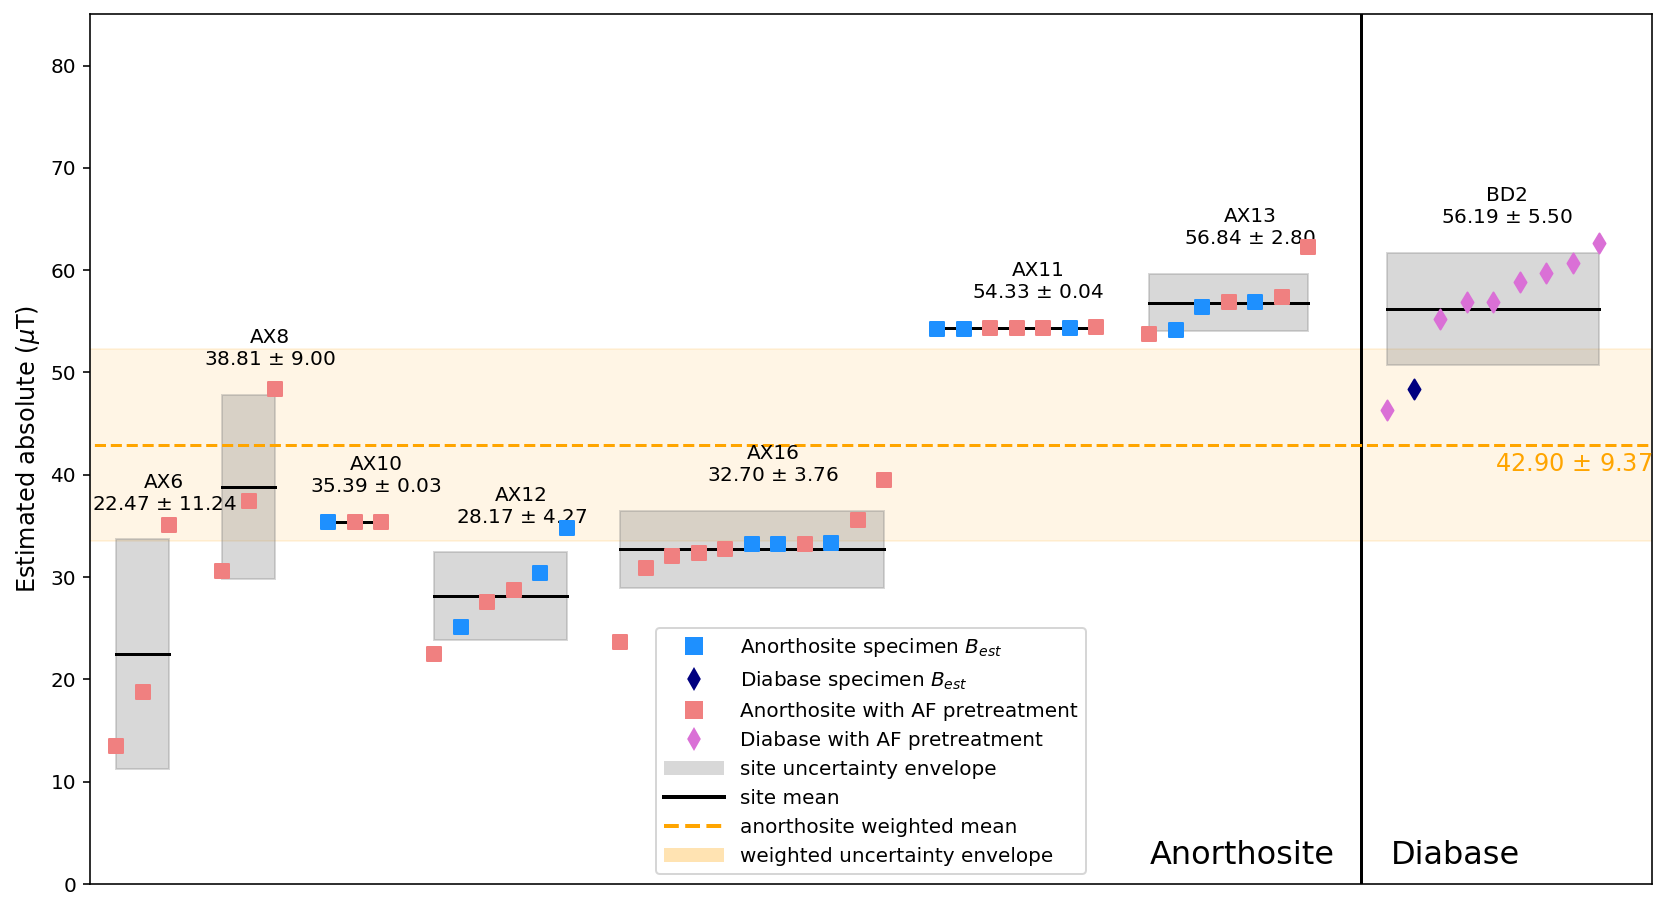

In [18]:
AX_PINT_data = get_PINT_data(AX_all_PINT_site, AX_all_PINT_specimen)
BD_PINT_data = get_PINT_data(BD_all_PINT_site, BD_all_PINT_specimen)

AX_site_mean_color = 'black'
AX_site_std_color = 'grey'
AX_spec_color = 'dodgerblue'
AX_grand_mean_color = 'orange'
AX_grand_std_color = 'orange'
BD_spec_color = 'navy'

fig, ax, mean, std = plot_PINT(AX_PINT_data[0], AX_PINT_data[1], [i/1.35 for i in (AX_PINT_data[2])], [j/1.35 for j in AX_PINT_data[3]], [k/1.35 for k in AX_PINT_data[4]], AX_PINT_data[5], All_AF_spec_list)

plt.vlines(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+8, 0, 105)

# lets add the only BD site data here
site_list, site_int_n, site_int, site_int_sigma_uT, spec_int_uT, spec_name_list = BD_PINT_data[0], BD_PINT_data[1], [i/1.35 for i in (BD_PINT_data[2])], [j/1.35 for j in BD_PINT_data[3]], [k/1.35 for k in BD_PINT_data[4]], BD_PINT_data[5]

current_site = len(AX_all_PINT_specimen.specimen_int_uT.tolist())+ 8 + 1
current_spec = 0

for i in range(len(site_list)):
    ax.plot([current_site, current_site + site_int_n[i] - 1], [site_int[i], site_int[i]], color = AX_site_mean_color)
    rectangle = matplotlib.patches.Rectangle((current_site, site_int[i]-site_int_sigma_uT[i]), site_int_n[i] - 1, 2*site_int_sigma_uT[i], color = AX_site_std_color, alpha = 0.3)
        
    ax.add_patch(rectangle)
        
    ax.text(current_site + site_int_n[i]/2, site_int[i] + site_int_sigma_uT[i] + 2.5,
                site_list[i] + '\n' + '%.2f' % site_int[i] + ' $\pm$ ' + '%.2f' % site_int_sigma_uT[i], size='10',horizontalalignment='center', verticalalignment='bottom', multialignment='center')
        
    # now lets put in little squares of specimen data into site mean plot
    for j in range(site_int_n[i]):
        if spec_name_list[current_spec + j] in All_AF_spec_list:
            ax.scatter(current_site + j, spec_int_uT[current_spec + j], marker = 'd', s = 50, color = 'orchid', zorder = 100)
        else:
            ax.scatter(current_site + j, spec_int_uT[current_spec + j], marker = 'd', s = 50, color = 'navy', zorder = 100)
    current_spec = current_spec + site_int_n[i]
    current_site = current_site + site_int_n[i] + 1

# labeling grand mean for AX
if plot_weighted_mean == True:
    ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+19, mean-2.5, '%.2f' % mean + ' $\pm$ ' + '%.2f' % std, color = AX_weighted_mean_color, horizontalalignment='right',fontsize=12)
    # making legends here
    custom_legends = [Line2D([0], [0], marker='s', color='w', markerfacecolor=AX_spec_color, markersize=10, label='Anorthosite specimen $B_{est}$'), 
                      Line2D([0], [0], marker='d', color='w', markerfacecolor=BD_spec_color, markersize=10, label='Diabase specimen $B_{est}$'), 
                      Line2D([0], [0], marker='s', color='w', markerfacecolor='lightcoral', markersize=10, label='Anorthosite with AF pretreatment'), 
                      Line2D([0], [0], marker='d', color='w', markerfacecolor='orchid', markersize=10, label='Diabase with AF pretreatment'), 
                        Patch(facecolor=AX_site_std_color, edgecolor='none', lw = 5, alpha = 0.3, label='site uncertainty envelope'),
                        Line2D([0], [0], color=AX_site_mean_color, lw=2, label = 'site mean'),
                        Line2D([0], [0], color=AX_weighted_mean_color, ls = 'dashed', lw=2, label = 'anorthosite weighted mean'),
                        Patch(facecolor=AX_grand_std_color, edgecolor='none', lw = 5, alpha = 0.3, label= 'weighted uncertainty envelope')]
else:
    ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+13.5, mean+1, '%.2f' % mean + ' $\pm$ ' + '%.2f' % std, color = AX_grand_mean_color, horizontalalignment='right',fontsize=12)
    # making legends here
    custom_legends = [Line2D([0], [0], marker='s', color='w', markerfacecolor=AX_spec_color, markersize=10, label='Anorthosite specimen $B_{est}$'), 
                      Line2D([0], [0], marker='d', color='w', markerfacecolor=BD_spec_color, markersize=10, label='Diabase specimen $B_{est}$'), 
                      Line2D([0], [0], marker='s', color='w', markerfacecolor='lightcoral', markersize=10, label='Anorthosite with AF pretreatment'), 
                      Line2D([0], [0], marker='d', color='w', markerfacecolor='orchid', markersize=10, label='Diabase with AF pretreatment'),  
                        Patch(facecolor=AX_site_std_color, edgecolor='none', lw = 5, alpha = 0.3, label='site uncertainty envelope'),
                        Line2D([0], [0], color=AX_site_mean_color, lw=2, label = 'site mean'),
                        Line2D([0], [0], color=AX_grand_mean_color, ls = 'dashed', lw=2, label = 'anorthosite grand mean'),
                        Line2D([0], [0], color=AX_grand_std_color, linestyle = 'dashed', lw=2, alpha = 0.5, label = 'grand uncertainty envelope')]

ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+7, 2, 'Anorthosite', horizontalalignment='right',fontsize=16)   
ax.text(len(AX_all_PINT_specimen.specimen_int_uT.tolist())+14, 2, 'Diabase', horizontalalignment='right',fontsize=16) 
ax.set_xlim(0, len(AX_all_PINT_specimen.specimen_int_uT.tolist())+10+len(BD_all_PINT_specimen.specimen_int_uT.tolist()))
ax.set_ylim(0,85)
ax.set_xticks([])
ax.set_ylabel('Estimated absolute ($\mu$T)', fontsize = 12)

plt.legend(handles = custom_legends, loc = 8, handlelength = 3)
# plt.title('Cooling rate corrected paleointensity estimates from the diabase and anorthosite')
plt.savefig('code_output/Paleointensity_plot_cooling_corrected.pdf', bbox_inches='tight')
plt.show(fig)

# Put paleointensity result in context of hitorical compilation

## Import data 

First we import data from relatively recent geological history. This ‘Recent’ data set is the same used in Biggin et al. (2015) and consists of measurements of VDM from the PINT database at the site-mean level that are derived from rocks with a stated age between 1 Myr and 300 Myr. Data further was filtered to only include results that met the STAT criterion and results from experiments that used the following techniques: T+ (Thellier with pTRM checks), M+ (Microwave with pTRM checks), LTD-DHT Shaw or some combination including at least one of these. To focus on the long-term average, we will look at values between 1 to 300 Ma (avoiding the high sampling of units 1 Ma or younger).

In [19]:
pd.set_option("display.max_rows",101)
Recent_PINT = pd.read_excel('../data/PINT_compilation/PINT_0_300Ma.xlsx', engine='openpyxl')
recent_PINT = Recent_PINT.loc[Recent_PINT.AGE > 0.99]
recent_values = recent_PINT['VDM/VADM']/10

Paleointensity estimates generated from the Midcontinent Rift and Abitibi dikes were downloaded from the IAGA Paleointensity database and our new data were added to these data in the same format. In the code below, the IAGA Paleointensity data plus our new data are imported and then data from the Midcontinent Rift are split up by study.

In [20]:
MCR_PINT_database = pd.read_csv('../data/PINT_compilation/MCR_PINT_data.csv', 
                                skiprows=2)

To separate Midcontinent Rift data, we organized it into groups based on study. The 'Ref' column refers to the studies that the data was taken from. Within this column, 
* '199' refers to data from the Abitibi dikes presented in Macouin et al. (2003)
* '54' refers to various Midcontinent rift units presented in Pesonen and Halls (1983)
* '687' refers to data from the Lake Shore Traps reported in Kulakov et al. (2013)
* 'this study' refers to new data presented here 

A new dataframe is made for data from each of these studies.

In [21]:
MCR_PINT_Abitibi = MCR_PINT_database.loc[MCR_PINT_database.Ref == '199']
MCR_PINT_PH = MCR_PINT_database.loc[MCR_PINT_database.Ref == '54']
MCR_PINT_LST = MCR_PINT_database.loc[MCR_PINT_database.Ref == '687']
MCR_PINT_volc = MCR_PINT_database.loc[MCR_PINT_database.Ref == '2018']
MCR_PINT_BBC = MCR_PINT_database.loc[MCR_PINT_database.Ref == 'this study']
MCR_PINT_BBC = MCR_PINT_BBC[MCR_PINT_BBC['IDENT'].str.contains('AX')]
MCR_PINT_BBC

,Data,IDENT,SLAT,SLONG,AGE,DAGE,AgeMtd,P,Country,Continent,...,DFPc,VDM,GROUP,TYPE,FORM,ROCKMAG,COMMENTS,LOCATION NAME,Ref,Changes from IAGA
64,NaN,AX6,47.582679,-90.856159,1092.8,1,U-Pb/correlation,N,U.S.A.,North America,...,50.01,4.84,Igneous,Anorthosite,Intrusion,PSD,NaN,Beaver Bay Complex,this study,NaN
65,NaN,AX8,47.582675,-90.856173,1092.8,1,U-Pb/correlation,N,U.S.A.,North America,...,23.18,8.25,Igneous,Anorthosite,Intrusion,PSD,NaN,Beaver Bay Complex,this study,NaN
66,NaN,AX10,47.582715,-90.856167,1092.8,1,U-Pb/correlation,N,U.S.A.,North America,...,0.09,7.78,Igneous,Anorthosite,Intrusion,PSD,NaN,Beaver Bay Complex,this study,NaN
67,NaN,AX12,47.292066,-91.260100,1092.8,1,U-Pb/correlation,N,U.S.A.,North America,...,15.15,5.22,Igneous,Anorthosite,Intrusion,PSD,NaN,Beaver Bay Complex,this study,NaN
68,NaN,AX16,47.288876,-91.263710,1092.8,1,U-Pb/correlation,N,U.S.A.,North America,...,11.50,6.43,Igneous,Anorthosite,Intrusion,PSD,NaN,Beaver Bay Complex,this study,NaN
69,NaN,AX11,47.369985,-91.166488,1092.8,1,U-Pb/correlation,N,U.S.A.,North America,...,0.08,12.26,Igneous,Anorthosite,Intrusion,PSD,NaN,Beaver Bay Complex,this study,NaN
70,NaN,AX13,47.368892,-91.166955,1092.8,1,U-Pb/correlation,N,U.S.A.,North America,...,4.92,12.86,Igneous,Anorthosite,Intrusion,PSD,NaN,Beaver Bay Complex,this study,NaN


We next separated the data from Pesonen and Halls (1983) based on geologic material which is indicated in the 'FORM' column. 

In [22]:
MCR_PINT_PH_intrusive = MCR_PINT_PH.loc[MCR_PINT_PH.FORM == 'Dyke ']
MCR_PINT_PH_flows = MCR_PINT_PH.loc[MCR_PINT_PH.FORM == 'Lava Flow ']
MCR_PINT_PH_baked = MCR_PINT_PH.loc[MCR_PINT_PH.FORM == 'Baked contact ']
MCR_PINT_PH_mixed = MCR_PINT_PH.loc[MCR_PINT_PH.FORM == 'Mixed']

Calculate the mean and standard deviation of paleointensity results from each study. Units are reported as $\text{ZAm}^2$.

In [23]:
print ("Mean of Pesonen and Halls")
print (np.mean(MCR_PINT_PH.VDM.tolist())*10)
print (np.std(MCR_PINT_PH.VDM.tolist())*10)
print ("\nMean of Sprain data")
print (np.mean(MCR_PINT_volc.VDM.tolist())*10)
print (np.std(MCR_PINT_volc.VDM.tolist())*10)
print ("\nMean of Abitibi")
print (np.mean(MCR_PINT_Abitibi.VDM.tolist())*10)
print (np.std(MCR_PINT_Abitibi.VDM.tolist())*10)
print ("\nMean of Lake Shore Traps")
print (np.mean(MCR_PINT_LST.VDM.tolist())*10)
print (np.std(MCR_PINT_LST.VDM.tolist())*10)
print ("\nMean of Sprain data + Lake Shore Traps")
print (np.mean(MCR_PINT_volc.VDM.tolist() + MCR_PINT_LST.VDM.tolist())*10)
print (np.std(MCR_PINT_volc.VDM.tolist() + MCR_PINT_LST.VDM.tolist())*10)
print ("\nMean of recent")
print (np.mean(recent_values.tolist())*10)
print (np.std(recent_values.tolist())*10)

Mean of Pesonen and Halls
95.77142857142859
30.027243865357672

Mean of Sprain data
55.60000000000001
20.597087172704786

Mean of Abitibi
13.000000000000004
3.625307868699863

Mean of Lake Shore Traps
55.56666666666666
9.93875690863243

Mean of Sprain data + Lake Shore Traps
55.57142857142856
12.052944428136847

Mean of recent
59.73031744664887
34.39006499475754


## Welch's T-tests

Conduct Welch's T-tests (assumes normal populations that have unequal variances) to test whether our new results share a common mean with past results from the Midcontinent Rift. If there is a large two-tailed p-value (i.e. large than 0.05 or 0.1), then the null hypothesis of identical averages cannot be rejected. 

In [24]:
stats.ttest_ind(MCR_PINT_PH.VDM.tolist(),
                MCR_PINT_volc.VDM.tolist(),
                equal_var=False)

Ttest_indResult(statistic=3.267570949241336, pvalue=0.011718386489727839)

In [25]:
stats.ttest_ind(MCR_PINT_LST.VDM.tolist(),
                MCR_PINT_volc.VDM.tolist(),
                equal_var=False)

Ttest_indResult(statistic=-0.003185948758165787, pvalue=0.99760163995563)

In [26]:
stats.ttest_ind(MCR_PINT_Abitibi.VDM.tolist(),
                MCR_PINT_volc.VDM.tolist(),
                equal_var=False)

Ttest_indResult(statistic=-4.094441697259933, pvalue=0.01373455542933557)

In [27]:
MCR_values_compiled = MCR_PINT_volc.VDM.tolist() + MCR_PINT_LST.VDM.tolist()
stats.ttest_ind(recent_values.tolist(),
                MCR_values_compiled,
                equal_var=False)

Ttest_indResult(statistic=1.333767228279037, pvalue=0.1844414529600742)

## Plotted vs. time
### Expected range associated with latitudinal motion

The intensity of the geomagnetic field varies as a function of latitude with the field being two times stronger at the pole than the equator. Given that Laurentia moved from high to low latitudes during the development of the Midcontinent Rift, a constant axial dipole moment over this period would result in a decrease in local intensity through the history of rift volcanism.

Our new paleointensity estimates from the Osler Volcanic Group give a paleointensity estimate of ~45 μT. We can use the function **pmag.b_vdm** to calculate the VDM implied by this local field intensity for a paleolatitude of 45º.

In [28]:
vadm = pmag.b_vdm(45e-6,45) 
print (vadm)

7.359788340581947e+22


Our best current estimates are that the rate of latitudinal motion from higher to lower latitudes occured at a relatively constant rate of 17 cm/year. Using this rate, we can calculate predicted local field strength for a constant virtual axial dipole moment of $7.4 \times 10^{22} \text{A m}^2$.

In [29]:
time = np.arange(1080,1111,.1)

deg_Myr = ((17.0/100000)/111.0)*1000000
vadm = pmag.b_vdm(45e-6,45) 
paleolat = []
expected_intensity = []

for t in time:
    time_delta = 1105 - t
    paleolat.append(44 - (time_delta*deg_Myr))

for lat in paleolat:
    expected_intensity.append(pmag.vdm_b(vadm,lat)*10**6)

intensity_1111Ma = expected_intensity[-1]    

old_time = []
for dates in np.arange (1111,1143):
    old_time.append(dates)
    expected_intensity.append(intensity_1111Ma)
    
time = np.append(time,old_time) 

This predicted change resulting from latitudinal motion can be plotted along with published and new paleointensity estimates.

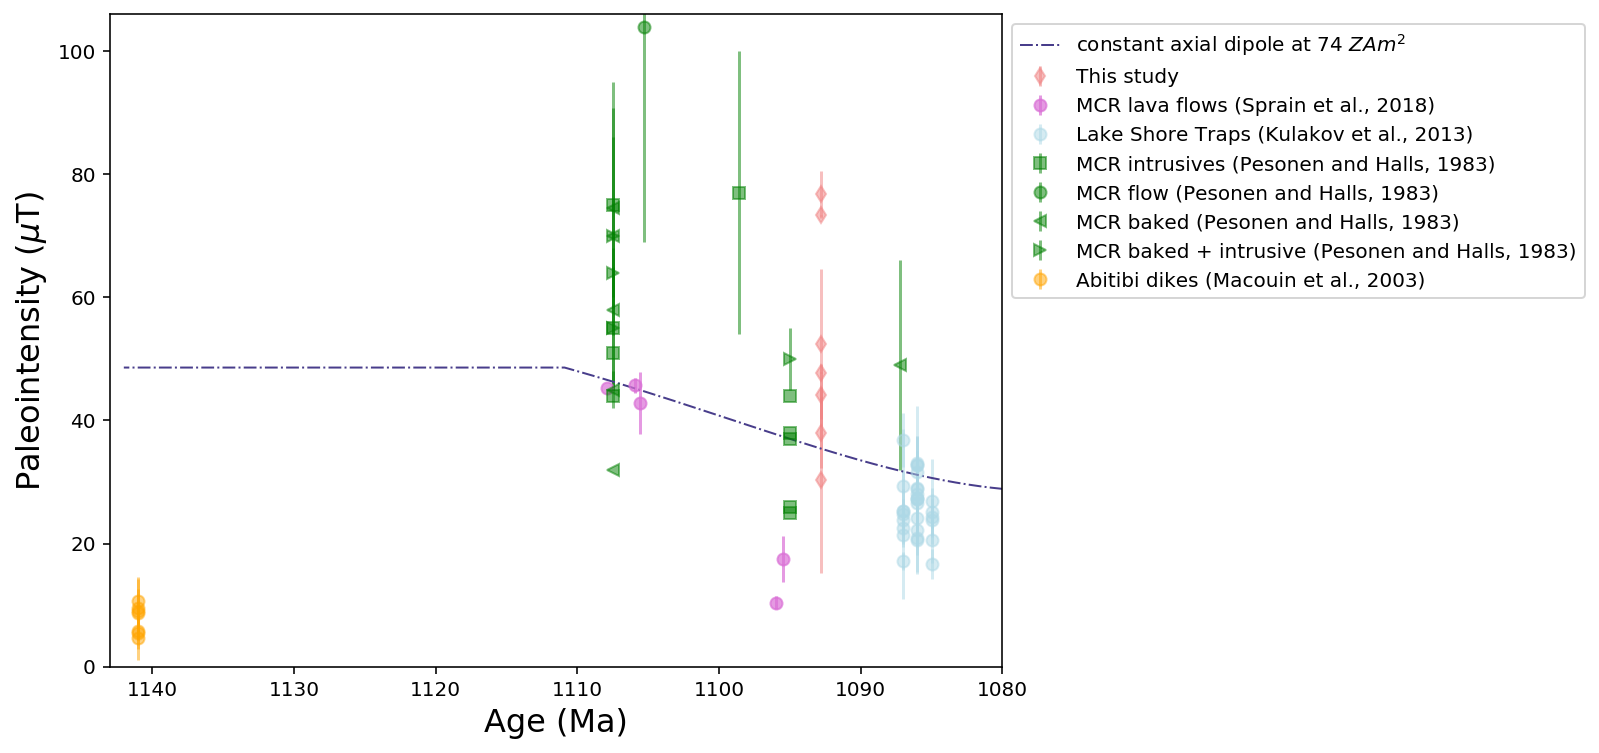

In [30]:
plt.figure(figsize=(8,6))
plt.errorbar(MCR_PINT_BBC['AGE'].tolist(),MCR_PINT_BBC['F'].tolist(), 
             yerr=MCR_PINT_BBC['DF'].tolist(), color='lightcoral',fmt ='d', 
             label = 'This study',
             alpha=0.5)
plt.errorbar(MCR_PINT_volc['AGE'].tolist(),MCR_PINT_volc['F'].tolist(), 
             yerr=MCR_PINT_volc['DF'].tolist(),color='orchid',fmt ='o', 
             label = 'MCR lava flows (Sprain et al., 2018)',alpha=0.7)
plt.errorbar(MCR_PINT_LST['AGE'].tolist(),MCR_PINT_LST['F'].tolist(), 
             yerr=MCR_PINT_LST['DF'].tolist(), color='lightblue', fmt ='o', 
             label = 'Lake Shore Traps (Kulakov et al., 2013)',alpha=0.5)
plt.errorbar(MCR_PINT_PH_intrusive['AGE'].tolist(),
             MCR_PINT_PH_intrusive['F'].tolist(), 
             yerr=MCR_PINT_PH_intrusive['DF'].tolist(),
             color='green',fmt ='s', 
             label = 'MCR intrusives (Pesonen and Halls, 1983)',alpha=0.5)
plt.errorbar(MCR_PINT_PH_flows['AGE'].tolist(),
             MCR_PINT_PH_flows['F'].tolist(), 
             yerr=MCR_PINT_PH_flows['DF'].tolist(),
             color='green',fmt ='o', 
             label = 'MCR flow (Pesonen and Halls, 1983)',alpha=0.5)
plt.errorbar(MCR_PINT_PH_baked['AGE'].tolist(),
             MCR_PINT_PH_baked['F'].tolist(), 
             yerr=MCR_PINT_PH_baked['DF'].tolist(),
             color='green',fmt ='<', 
             label = 'MCR baked (Pesonen and Halls, 1983)',alpha=0.5)
plt.errorbar(MCR_PINT_PH_mixed['AGE'].tolist(),
             MCR_PINT_PH_mixed['F'].tolist(), 
             yerr=MCR_PINT_PH_mixed['DF'].tolist(),
             color='green',fmt ='>', 
             label = 'MCR baked + intrusive (Pesonen and Halls, 1983)',
             alpha=0.5)
plt.errorbar(MCR_PINT_Abitibi['AGE'].tolist(),MCR_PINT_Abitibi['F'].tolist(), 
             yerr=MCR_PINT_Abitibi['DF'].tolist(), color='orange',fmt ='o', 
             label = 'Abitibi dikes (Macouin et al., 2003)',
             alpha=0.5)

plt.plot(time,expected_intensity, label='constant axial dipole at 74 $ZAm^2$', 
         c='darkslateblue', linestyle='dashdot', linewidth=1)
plt.xlim(1080,1143)
plt.ylim(0,106)
plt.ylabel(r'Paleointensity ($\mu$T)', fontsize = 16)
plt.xlabel('Age (Ma)', fontsize = 16)
plt.legend(loc='upper left', prop={'size':10}, bbox_to_anchor=(1,1))
plt.gca().invert_xaxis()
# plt.savefig('../figure/MCR_Paleointensity.pdf', bbox_inches='tight')
plt.show()

In [31]:
all_MCR = pd.concat([MCR_PINT_BBC, MCR_PINT_volc, MCR_PINT_LST, MCR_PINT_PH_intrusive, MCR_PINT_PH_flows, MCR_PINT_PH_baked, MCR_PINT_PH_mixed])
MCR_median = all_MCR['VDM'].median()*10
MCR_median

64.3

In [32]:
np.std(all_MCR['VDM']*10)

28.798136102586902

In [33]:
np.mean(all_MCR['VDM']*10)

71.94603174603175

In [34]:
MCR_PINT_BBC['VDM'].median()*10

77.8

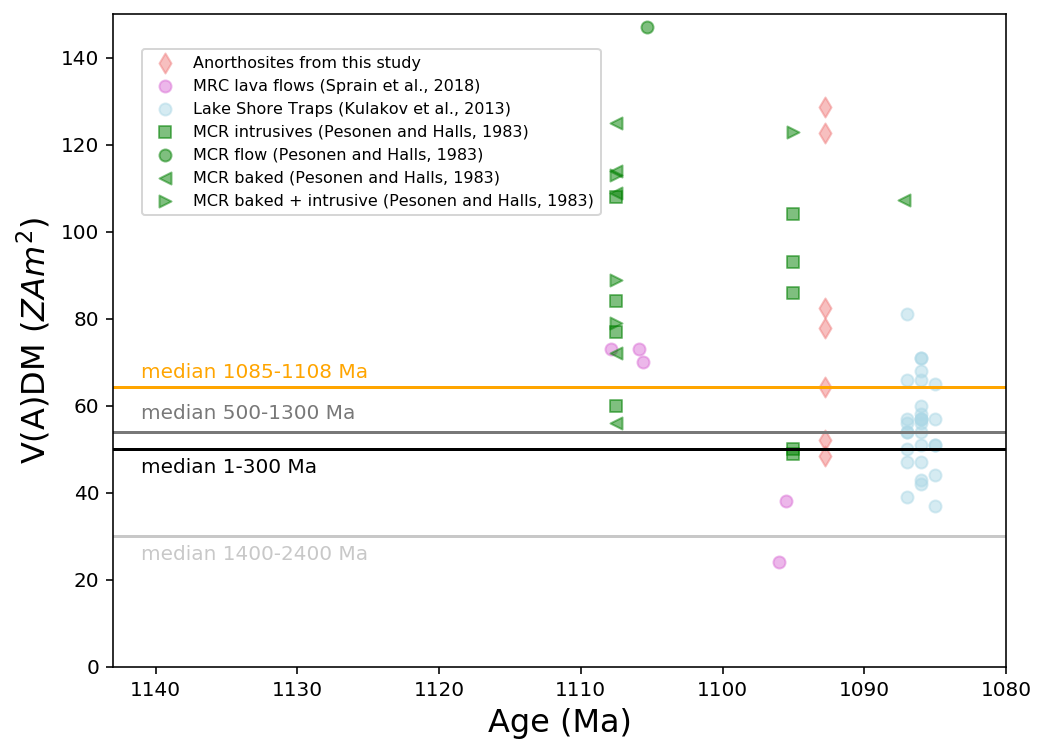

In [59]:
plt.figure(figsize=(8,6))
plt.scatter(MCR_PINT_BBC['AGE'],MCR_PINT_BBC['VDM']*10, s = 50,
             color='lightcoral',marker ='d', 
            label = 'Anorthosites from this study',alpha=0.5)
plt.scatter(MCR_PINT_volc['AGE'],MCR_PINT_volc['VDM']*10, 
             color='orchid',marker ='o', 
            label = 'MRC lava flows (Sprain et al., 2018)',alpha=0.5)
plt.scatter(MCR_PINT_LST['AGE'],MCR_PINT_LST['VDM']*10, 
             color='lightblue',marker ='o',
            label = 'Lake Shore Traps (Kulakov et al., 2013)',alpha=0.5)
plt.scatter(MCR_PINT_PH_intrusive['AGE'],MCR_PINT_PH_intrusive['VDM']*10, 
             color='green',marker ='s', 
            label = 'MCR intrusives (Pesonen and Halls, 1983)',alpha=0.5)
plt.scatter(MCR_PINT_PH_flows['AGE'],MCR_PINT_PH_flows['VDM']*10, 
             color='green',marker ='o', 
            label = 'MCR flow (Pesonen and Halls, 1983)',alpha=0.5)
plt.scatter(MCR_PINT_PH_baked['AGE'],MCR_PINT_PH_baked['VDM']*10, 
             color='green',marker ='<', 
            label = 'MCR baked (Pesonen and Halls, 1983)',alpha=0.5)
plt.scatter(MCR_PINT_PH_mixed['AGE'],MCR_PINT_PH_mixed['VDM']*10, 
             color='green',marker ='>', 
            label = 'MCR baked + intrusive (Pesonen and Halls, 1983)',alpha=0.5)
# plt.scatter(MCR_PINT_Abitibi['AGE'],MCR_PINT_Abitibi['VDM']*10, 
#              color='orange',marker ='o', 
#             label = 'Abitibi dikes (Macouin et al., 2003)',alpha=0.5)

plt.xlim(1080,1143)
plt.ylim(0,150)

plt.axhline(y=50,color='#000000')
plt.text(1141,48,'median 1-300 Ma',color='#000000',
         verticalalignment='top')
plt.axhline(y=54,color='#787878')
plt.text(1141,56,'median 500-1300 Ma',color='#787878',
         verticalalignment='bottom')
plt.axhline(y=30,color='#C8C8C8')
plt.text(1141,28,'median 1400-2400 Ma',color='#C8C8C8',
         verticalalignment='top')

plt.axhline(y=MCR_median,color='orange')
plt.text(1141,MCR_median+5.5,'median 1085-1108 Ma',color='orange',
         verticalalignment='top')

plt.ylabel(r'V(A)DM $(ZAm^2)$', fontsize = 16)
plt.xlabel('Age (Ma)', fontsize = 16)
plt.legend(bbox_to_anchor=(0.555,0.68), prop={'size':8})
plt.gca().invert_xaxis()
# plt.savefig('code_output/MCR_VADM.pdf', bbox_inches='tight')
plt.show()